In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"

from utils.objective_function import jax_model, objective_model, Parameter_Index
from utils.new_SLD_utils import DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, EMP_PSF, DustEllipticalDistribution2PowerLaws, Winnie_PSF
from utils.SLD_ojax import ScatteredLightDisk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

/home/mihirkondapalli/anaconda3/envs/jwst_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).


In [2]:
spf_params = DoubleHenyeyGreenstein_SPF.params
psf_params = EMP_PSF.params

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

In [3]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, EMP_PSF)

772 μs ± 1.09 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


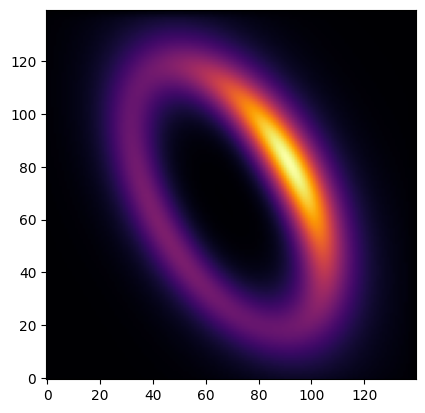

In [4]:
plt.imshow(img, origin='lower', cmap='inferno')

In [5]:
#############################################
######### Read in NIRCam model PSFs #########
#############################################

x1 = 0
x2 = 4096
y1 = 0
y2 = 4096

##################### F300M #################
psf_dir = "for_mihir_20241218/F300M/"
psf_suffixes = "_F300M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

nircam_psf_list_f300m = [psfs,psf_inds_rolls,im_mask_rolls,unique_inds]

psf_dir = "for_mihir_20241218/F360M/"
psf_suffixes = "_F360M.npy"

#Read in the pre-generated PSFs
im_mask_rolls = jnp.load(psf_dir+"im_mask_rolls"+psf_suffixes)
psf_inds_rolls = jnp.load(psf_dir+"psf_inds_rolls"+psf_suffixes)
psf_offsets = jnp.load(psf_dir+"psf_offsets"+psf_suffixes)
psfs = jnp.load(psf_dir+"psfs"+psf_suffixes)

unique_inds = jnp.unique(psf_inds_rolls)
n_unique_inds = len(unique_inds)

test_parangs = jnp.unique(np.linspace(-45, 45, 8))

In [6]:
spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = Winnie_PSF.init(psfs, psf_inds_rolls, im_mask_rolls, psf_offsets, test_parangs, 46)

disk_params = Parameter_Index.disk_params
disk_params['sma'] = 40
disk_params['inclination'] = 60
disk_params['position_angle'] = 30

img = objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF)

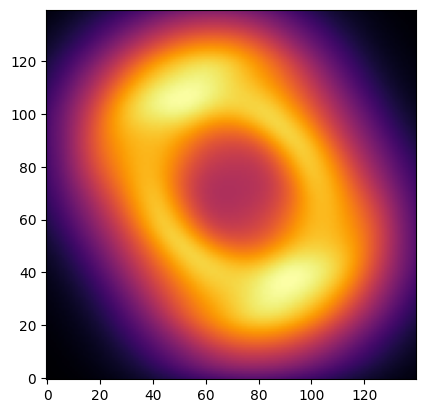

In [7]:
plt.imshow(img, origin='lower', cmap='inferno')

In [8]:
%timeit objective_model(disk_params, spf_params, psf_params, Parameter_Index.misc_params, ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, Winnie_PSF)

14.7 ms ± 21.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
